# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [27]:
import os
print(os.listdir("../input"))

['powerco-bcg', 'powerco']


In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
# Import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt


# Import modeling library
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# SMOTE
from imblearn.over_sampling import SMOTE

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

We first load the data and check the data frame to see if there is any na values or other factors that may affect our analysis. 

In [30]:
df = pd.read_csv('../input/powerco/data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_discount_energy                    14606 non-null  float64
 6   forecast_meter_rent_12m                     14606 non-null  float64
 7   forecast_price_energy_off_peak              14606 non-null  float64
 8   forecast_price_energy_peak                  14606 non-null  float64
 9   forecast_price_pow_off_peak                 14606 non-null  float64
 10  has_gas   

In [31]:
# Drop columns
dropped_columns = ['id']

#dropped_columns = ['id', 'margin_net_pow_ele', 'var_year_price_off_peak_var', 
#                   'var_year_price_peak_var', 'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix', 
#                   'var_year_price_peak_fix' ,'var_year_price_mid_peak_fix', 'var_year_price_off_peak', 
#                   'var_year_price_peak', 'var_year_price_mid_peak']

df.drop(columns = dropped_columns, inplace = True)

In [32]:
# Recheck the correlation heatmap
plt.figure(figsize = (100, 100))
sns.heatmap(df.corr(), vmin = -1, vmax = 1, cmap = 'RdBu', annot = True, linewidth = .5)
plt.show()

---

## 3. Modelling

### Train-test split and Data Sampling

In [33]:
# Useful function:
def graphFeatureImportance(importance):
    num_features = len(importance)
    
    plt.figure(figsize=(15, num_features / 2))
    plt.title('Feature Importances')
    plt.barh(range(num_features), importance['importance'])
    plt.yticks(range(num_features), importance['features'])
    plt.xlabel('Importance')
    plt.vlines(0.01, ymin=-1, ymax=num_features-1, colors='Red')
    plt.show()
    
def printMetricsEval(y_test, rfc_prediction):
    print('Confusion Matrix\n', confusion_matrix(y_test,
                                            rfc_prediction))
    print(f"Accuracy: {metrics.accuracy_score(y_test, rfc_prediction)*100:.2f}")
    print(f"Precision: {metrics.precision_score(y_test, rfc_prediction)*100:.2f}")
    print(f"Recall: {metrics.recall_score(y_test, rfc_prediction)*100:.2f}")
    print(f"F1-score: {metrics.f1_score(y_test, rfc_prediction)*100:.2f}")
    
    
def crossEvalSocre(X_train, y_train, rfc):
    k_fold = KFold(n_splits = 10, shuffle = True, random_state = 12152001)
    rfc_cvc = (cross_val_score(rfc, X_train, y_train, 
                           cv = k_fold, n_jobs = 2, scoring = 'accuracy').mean())
    models = pd.DataFrame({
        'Models' : ['Random Forest Classifier'],
        'Score' : [rfc_cvc]
    })
    
    return models

def data_split(X, y):
    # 70-30 train test split
    X_train, X_test,y_train, y_test = train_test_split(X, y,
                                           random_state = 12152001, 
                                           test_size = 0.3, 
                                           shuffle = True)
    return X_train, X_test,y_train, y_test

In [34]:
# Split features and dependent variables
X = df.loc[:, df.columns != 'churn']
y = df['churn']

X_train, X_test,y_train, y_test = data_split(X, y)

Since our predicting variable, `churn` is highly-skewed (90% - 0, 10% - 1), we can oversample minor group in our training dataset to avoid bias toward the majority group.

In [35]:
smote = SMOTE()

X_train, y_train = smote.fit_resample(X_train, y_train)

In [36]:
y_train.value_counts()

churn
0    9241
1    9241
Name: count, dtype: int64

In [37]:
X_train.describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  18482.000000  18482.000000     18482.000000       18482.000000   
mean       4.214409      0.689298         2.218007           2.973731   
std        0.811545      1.517400         1.647523           0.663032   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.784564      0.000000         0.000000           2.700195   
50%        4.166696      0.000000         2.767388           3.053817   
75%        4.612063      0.000000         3.463557           3.394434   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_discount_energy  forecast_meter_rent_12m  \
count              18482.000000             18482.000000   
mean                   1.088034                 1.544220   
std                    5.190446                 0.552804   
min                    0.000000                 0.000000   
25%                    0.000000                 1.233781   
50%                    0.000000                 1.308351   
75%                    0.000000                 2.121822   
max                   30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    18482.000000                18482.000000   
mean                         0.136749                    0.052327   
std                          0.022922                    0.048114   
min                          0.000000                    0.000000   
25%                          0.115989                    0.000000   
50%                          0.143166                    0.081210   
75%                          0.146387                    0.099214   
max                          0.273963                    0.168092   

       forecast_price_pow_off_peak       has_gas  ...  months_modif_prod  \
count                 18482.000000  18482.000000  ...       18482.000000   
mean                     43.175395      0.111676  ...          33.281788   
std                       3.816980      0.314976  ...          28.676959   
min                       0.000000      0.000000  ...           0.000000   
25%                      40.606701      0.000000  ...           6.000000   
50%                      44.311378      0.000000  ...          26.000000   
75%                      44.311378      0.000000  ...          59.000000   
max                      59.266378      1.000000  ...         151.000000   

       months_renewal  channel_MISSING  \
count    18482.000000     18482.000000   
mean         4.716481         0.183422   
std          3.509727         0.387022   
min          0.000000         0.000000   
25%          2.000000         0.000000   
50%          4.000000         0.000000   
75%          7.000000         0.000000   
max         29.000000         1.000000   

       channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
count                              18482.000000   
mean                                   0.038903   
std                                    0.193368   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%                                    0.000000   
max                                    1.000000   

       channel_foosdfpfkusacimwkcsosbicdxkicaua  \
count                              18482.000000   
mean                                   0.431663   
std                                    0.495321   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%                                    1.000000   
max                                    1.000000   

       channel_lmkebamcaaclubfxadlmueccxoimlema  \
count                              18482.000000   
mean                                   0.072774   
std                                    0.259771   
mi

### Standardize

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Random Forest Classifier

In [39]:
# Add model training in here!
rfc = RandomForestClassifier(n_estimators = 200,
                            n_jobs = 2,
                            random_state = 12152001)
rfc.fit(X_train, y_train)
rfc_prediction = rfc.predict(X_test)

### Evaluation


#### Cross validation score

In [40]:
crossEvalSocre(X_train, y_train, rfc)

Models     Score
0  Random Forest Classifier  0.953901

So on average, our model has 90% accuracy rate whem predicting customer`churn`

#### Confusion Matrix

Confuion matrix is a helpful tool to evaluate our classification, as we can evaluate accuracy, precision, recall and F1-score of our model

In [41]:
printMetricsEval(y_test, rfc_prediction)

Confusion Matrix
 [[1606 2340]
 [ 137  299]]
Accuracy: 43.47
Precision: 11.33
Recall: 68.58
F1-score: 19.45


We can tell that the `precision`, which is the ability to find the true positive is quite low. We can proceed to find which metrics is important to hopefully increase this

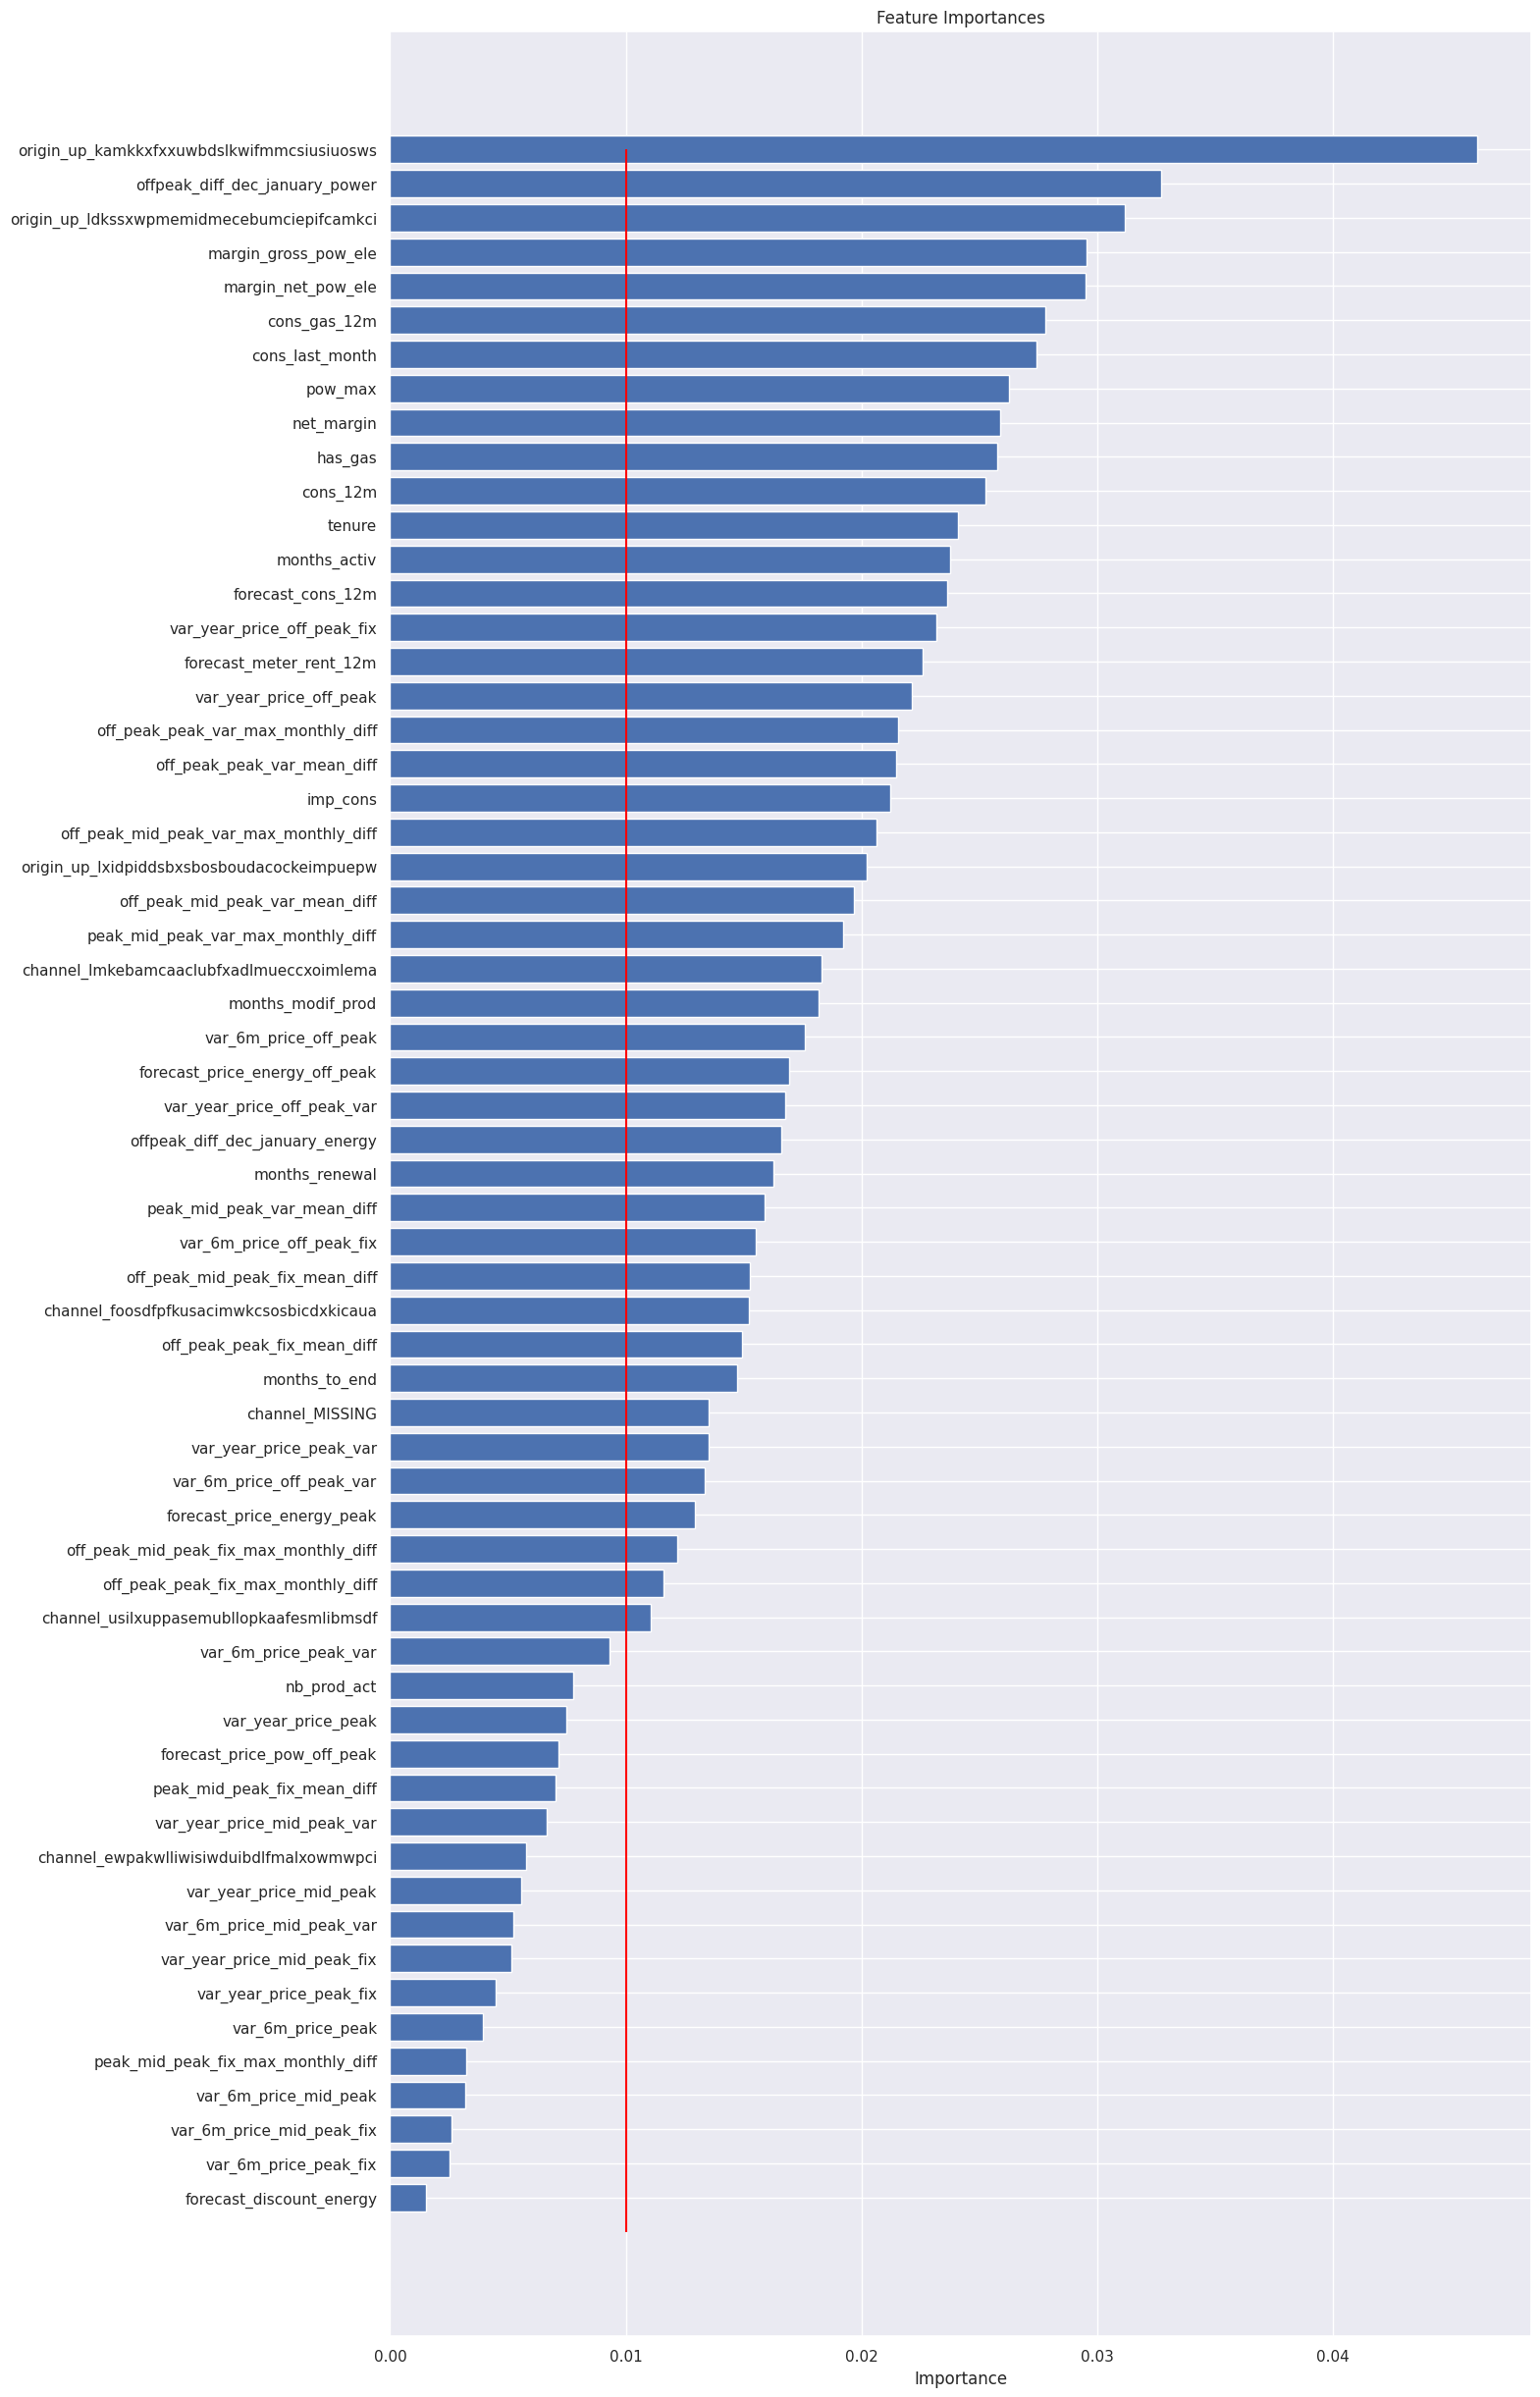

In [42]:
importance = pd.DataFrame({
    'features': X.columns,
    'importance': rfc.feature_importances_
}).sort_values(by = 'importance', ascending = True)
graphFeatureImportance(importance)

We can tell that price is a factor that affect customer `churn`, but not much of a driving factor.

To improve our model, there are two methods that can be helpful: **PCA** and **Feature Selection**

## Model Improvement

### Manual Feature Selection

Intuitively, we can get rid of the features that contribute less than 1% to the prediction of our model"

In [43]:
# Step 1: Extract important features
new_features = importance[importance['importance'] >= 0.015]['features'].tolist()

# Step 2: Use the list to index the training and testing sets
X1 = X[new_features]
y1 = y.copy()
X1, y1 = smote.fit_resample(X1,y1)

X_train1, X_test1, y_train1, y_test1 = data_split(X1, y1)

In [44]:
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.fit_transform(X_test1)

# Add model training in here!
rfc1 = RandomForestClassifier(n_estimators = 200,
                            n_jobs = 2,
                            random_state = 12152001)
rfc1.fit(X_train1, y_train1)
rfc1_prediction = rfc1.predict(X_test1)

In [45]:
crossEvalSocre(X_train1, y_train1, rfc1)

Models     Score
0  Random Forest Classifier  0.947348

In [46]:
printMetricsEval(y_test1, rfc1_prediction)

Confusion Matrix
 [[3076  864]
 [ 517 3456]]
Accuracy: 82.55
Precision: 80.00
Recall: 86.99
F1-score: 83.35


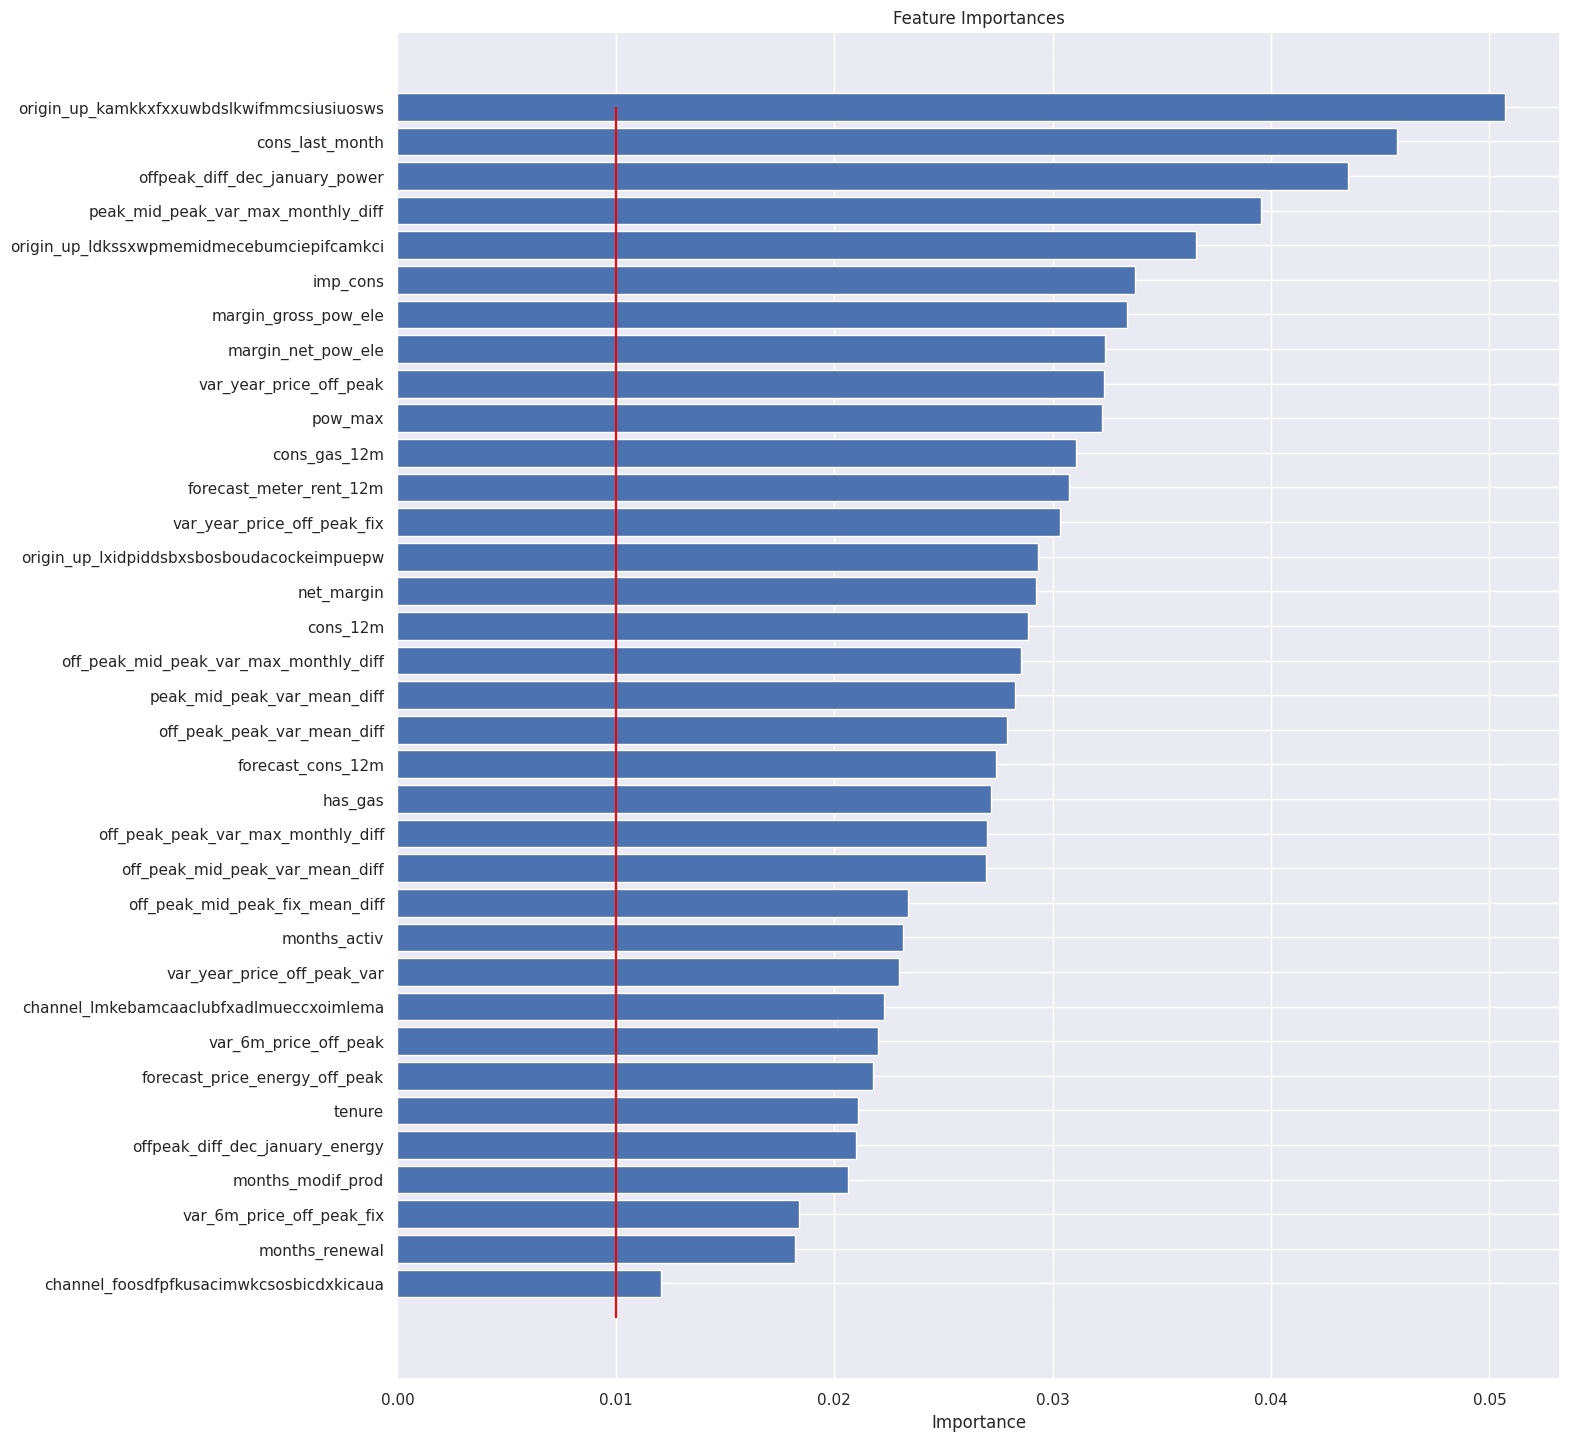

In [47]:
importance1 = pd.DataFrame({
    'features': X1.columns,
    'importance': rfc1.feature_importances_
}).sort_values(by = 'importance', ascending = True)
graphFeatureImportance(importance1)

We can see that the precision greatly increases.

### PCA
Different from manual feature selection, PCA does not drop any columns. It "merges" columns based on their linear dependency to a lower dimension space

In [48]:
from sklearn.decomposition import PCA

def pca_plot(X, n_components = 10):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components = n_components)
    pca.fit_transform(X)
    ex_ratio= pca.explained_variance_ratio_
    # Scree Plot
    plt.figure(figsize = (50,10))
    plt.plot(range(1, n_components +1),ex_ratio, 'o-', markersize = 8)
    plt.xlabel('Number of Components')
    plt.ylabel('Cummulative Explained Variance')
    plt.title('Scree Plot')
    plt.xticks(range(1, n_components+1))
    
    # Cummulative Proportion of Variance Explained
    cummulative_variance_explained_ratio = np.cumsum(ex_ratio)
    plt.figure(figsize = (50,10))
    plt.plot(range(1, n_components +1),cummulative_variance_explained_ratio, 'o-', markersize = 8)
    plt.axhline(y = 0.95, color = 'r', linestyle = '--', label = '95% explained ratio')
    plt.axhline(y = 0.99, color = 'r', linestyle = '--', label = '99% explained ratio')
    plt.legend(loc = 'best')
    plt.show()

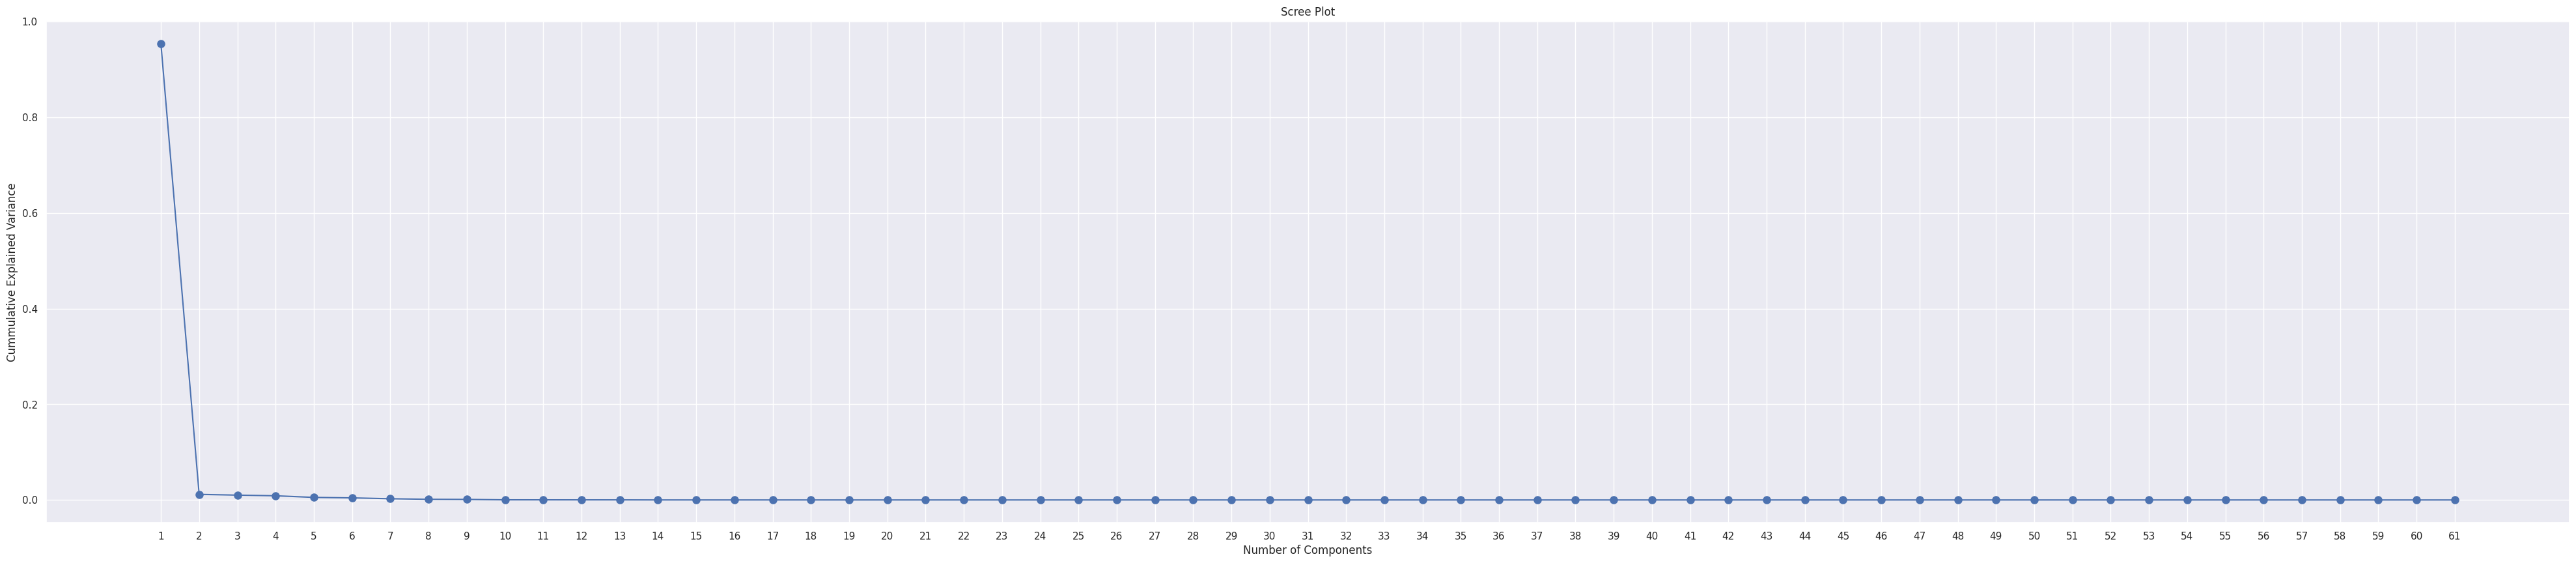

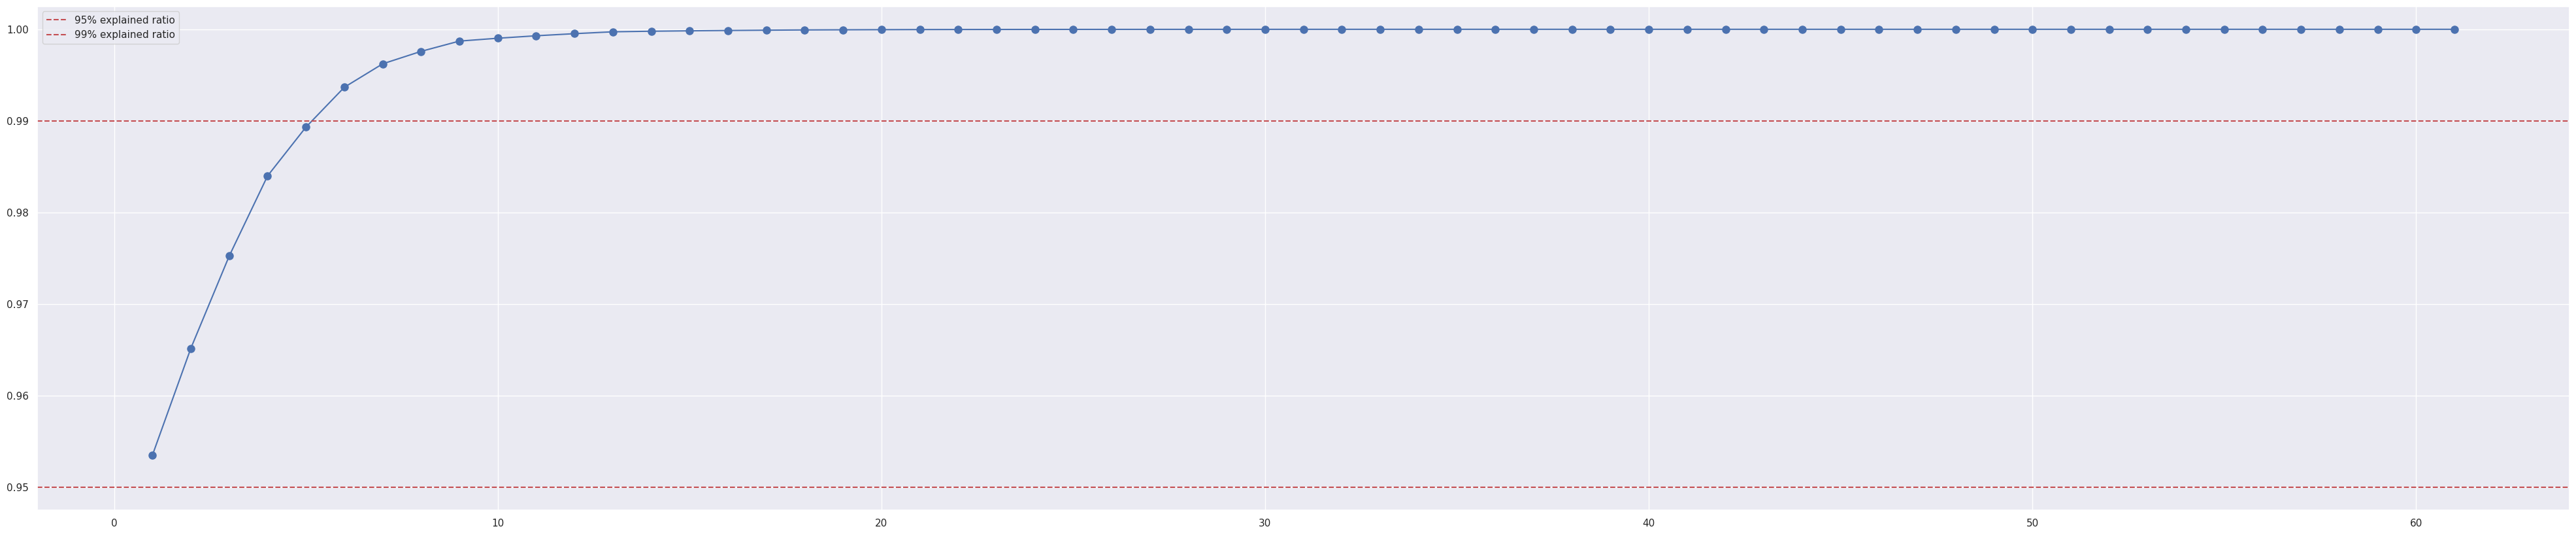

In [49]:
X_pca = X.copy()
pca_plot(X, n_components = X.columns.size)

We can see at around 14 component, almost 100% of X can be explained 

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA with the specified number of components
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)
y_pca = y.copy()

# Smote
X_pca, y_pca = smote.fit_resample(X_pca, y_pca)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = data_split(X_pca, y_pca)

In [51]:
# Add model training in here!
rfc_pca = RandomForestClassifier(n_estimators = 200,
                            n_jobs = 2,
                            random_state = 12152001)
rfc_pca.fit(X_train_pca, y_train_pca)
rfc_pca_prediction = rfc_pca.predict(X_test_pca)

In [52]:
crossEvalSocre(X_train_pca, y_train_pca, rfc_pca)

Models    Score
0  Random Forest Classifier  0.92346

In [53]:
printMetricsEval(y_test_pca, rfc_pca_prediction)

Confusion Matrix
 [[3595  345]
 [ 207 3766]]
Accuracy: 93.02
Precision: 91.61
Recall: 94.79
F1-score: 93.17
